# Tutorial on Tensor Network States Algorithms
1. Review of numerical methods to solve quantum manybody systems
2. Brief introduction on tensor network states algorithms
3. Implementation of variational matrix product states algorithm from scratch
4. Implementation of time-evolving block decimation (TEBD) algorithm from scratch
5. More advanced topics

## Part 1: Review of numerical methods to solve large-scale quantum manybody systems

### An extremely important quantum manybody system: the motion of interacting electrons in solids
- Model from __first principle__ $\hat{H} = \sum_{i} \left( -\frac{\hbar^2}{2m} \right)\nabla_i^2 + \frac{1}{2}\sum_{i, j} \frac{e^2}{\vert r_i - r_j\vert } - \sum_{i, l} \frac{Z e^2}{\vert r_i - R_l\vert } $
- Strongly corrected lattice models
    - Hubbard model
    - Anderson impurity model
    - Kondo model
    - Heisenberg spin chain
    - ...

### An overview of existing numerical methods
- Weakly correlated quantum manybody systems
    - Density functional theory (DFT), suitable for __nearly free__ electrons  
- Strongly correlated quantum manybody systems
    - 2D and above
        - Mean field theory (can not get dynamical information)
        - Monte Carlo algorithm (suffer from sign problem)
        - Infinite projected entangled pair states (iPEPS, tensor network states in 2D)
        - Dynamical mean field theory (DMFT) 
    - 1D
        - Matrix product states (MPS, tensor network states in 1D)
        - Infinite matrix product states (for infinite system)

### Additional notes on numerical methods for strongly correlated quantum manybody systems
- MPS is usually the **algorithm of choice** for strongly correlated quantum manybody system in 1D
- Strongly correlated quantum manybody system beyond 2D are generally __very difficult__ to solve, currently DMFT, iPEPS and Monte Carlo (if there is no sign problem) are the most popular algorithms
- The performance of DMFT is strongly dependent on an efficient impurity solver, which is often implemented using either Monte Carlo or MPS algorithm.

## Part 2: Brief introduction on tensor network states algorithms

### History of TNS algorithms
- K. G. Wilson __numerical renormalization group__ theory for solving Kondo model (1961)
- Steve White invented __Density Matrix Renormalization Group__ method, with two versions for both finite and infinite systems. The __finite version__ has achieved great success very soon for many one-dimensional systems (PRL, 69, 19, 1992 and PRB 48, 14, 1993)
- D. Vidal et.al introduced the __Matrix Product States__ representation of quantum many-body states (MPS is equivalent to DMRG in 1D, but allows more elegant coding as well as easier generalization to high dimensions) (PRL, 91, 147902, 2003)
- Infinite MPS, Variational uniform MPS, Tree Tensor Network, MERA, PEPS, iPEPS...

## Part 3: Implementation of variational matrix product states algorithm from scratch

### Main knowledge required from linear algebra:
1. Tensor contract (Einstein summation)
2. Singular value decomposition $svd(A) = U * S * V$
3. (Sparse) eigenvalue decomposition $A x = x \lambda$

In [1]:
using LinearAlgebra
using TensorOperations # used for tensor contrac

In [2]:
a = randn(3,4,5)
b = randn(2,3,5,7)

@tensor r[y, u, w] := a[x, y, z] * b[u, x, z, w]

size(r)

(4, 2, 7)

In [3]:
a = rand(3, 4)
u, s, v = svd(a)
println("u size = $(size(u)), s size = $(size(s)), v size = $(size(v))")
println(isapprox(u * Diagonal(s) * v', a))

u size = (3, 3), s size = (3,), v size = (4, 3)
true


The svd convention for v maybe different from other language!!!, I prefer to use the following convention.

In [4]:
function mysvd(a)
    u, s, v = svd(a)
    return u, s, v'
end

mysvd (generic function with 1 method)

In [5]:
a = randn(4, 4)
a = a + a'

lambdas, x = eigen(Symmetric(a))

println(isapprox(a * x, x * Diagonal(lambdas)))

true


#### Sparse eigensolver

In [6]:
using KrylovKit

In [7]:
a = rand(100, 100)
a = a + a'

lambdas, x, info = eigsolve(a, randn(size(a, 1)), 2, :SR, ishermitian=true)
println("number of converged eigenpairs is $(info.converged), the lowest eigenvalues are $(lambdas)")

number of converged eigenpairs is 2, the lowest eigenvalues are [-7.762135009299872, -7.585366345476228]


### A. Matrix product states representation of quantum state

MPS is a chain of three-dimensional tensors, written as ${\rm MPS} = \sum_{a_1, a_2, \dots, a_L}M^{\sigma_1}_{a_1, a_{2}} M^{\sigma_2}_{a_2, a_3} \dots M^{\sigma_L}_{a_L, a_{L+1}}$, with each tensor represented as
$M^{\sigma_l}_{a_l, a_{l+1}}$ = <img src="mpstensor.png" width="200" height="200" />. We will use <span style="color:red">$\sigma_l$</span> to represent the __<span style="color:red">physical</span>__ indices, and $a_l$ for the __auxiliary__ indices. The maximum size of the auxiliary indices $a_l$ is refered to as the __bond dimension__, writte as $D$.

#### Why MPS is useful?

- An $n$-qubit quantum state does not have to be stored in the standard way as an $n$-dimensional tensor
- MPS can efficiently (polynomial) represent a class of quantum states with __a finite amount of entanglement__

#### Examples of MPS
An elegant way to write down an MPS analytically - write each 3-dimensional tensor as a matrix, with entry to be a vector
- Product state with no entanglement, for example for $\vert 00\dots 0 \rangle = [\vert 0\rangle]\times[\vert 0\rangle] \dots \times[\vert 0\rangle] $ with $D=1$
- GHZ state $\vert 00\dots 0 \rangle + \vert 11 \dots 1 \rangle = \left[\begin{array}{cc} \vert 0\rangle & \vert 1\rangle \end{array}\right] \times \left[\begin{array}{cc} \vert 0\rangle & 0 \\ 0 & \vert 1\rangle \end{array}\right] \dots \times \left[\begin{array}{cc} \vert 0\rangle \\ \vert 1\rangle \end{array}\right] $ with $D=2$

Only $D^2L$ complex numbers needs to be stored for an $L$-qubit MPS!

MPS representation is not unique, several __Canonical form__ of MPS are often used
- MPS is said to be __left-canonical__ if each tensor $M^{\sigma_l}_{a_l, a_{l+1}}$ satisfied $\sum_{\sigma_l, a_l}M^{\sigma_l}_{a_l, a_{l+1}} {\rm conj}(M^{\sigma_l}_{a_l, a'_{l+1}}) = I_{a_{l+1}, a'_{l+1}}$. In this case we often write ${\rm MPS} = \sum_{a_1, a_2, \dots, a_L}A^{\sigma_1}_{a_1, a_{2}} A^{\sigma_2}_{a_2, a_3} \dots A^{\sigma_L}_{a_L, a_{L+1}}$
- MPS is said to be __right-canonical__ if each tensor $M^{\sigma_l}_{a_l, a_{l+1}}$ satisfied $\sum_{\sigma_l, a_{l+1}}M^{\sigma_l}_{a_l, a_{l+1}} {\rm conj}(M^{\sigma_l}_{a'_l, a_{l+1}}) = I_{a_{l}, a'_{l}}$. In this case we often write ${\rm MPS} = \sum_{a_1, a_2, \dots, a_L}B^{\sigma_1}_{a_1, a_{2}} B^{\sigma_2}_{a_2, a_3} \dots B^{\sigma_L}_{a_L, a_{L+1}}$
- MPS is said to be __mixed-canonical on site l__ if ${\rm MPS} = \sum_{a_1, a_2, \dots, a_L}A^{\sigma_1}_{a_1, a_{2}} \dots A^{\sigma_{l-1}}_{a_{l-1}, a_l} M^{\sigma_{l}}_{a_{l}, a_{l+1}} B^{\sigma_{l+1}}_{a_{l+1}, a_{l+2}}  \dots B^{\sigma_L}_{a_L, a_{L+1}}$

For reasons that will become clear later, for variational MPS algorithm mixed-canonical is used, while for TEBD algorithm either left-canonical or right-canonical form is used.

#### In practice the MPS is random generated, which can be done as

In [8]:
function generate_random_mps(::Type{T}, L::Int, d::Int, D::Int) where {T <: Number}
    (L >= 2) || error("number of sites must be larger than 1")
    mps = Vector{Array{T, 3}}(undef, L)
    mps[1] = randn(T, 1, d, D)
    mps[L] = randn(T, D, d, 1)
    for i in 2:L-1
        mps[i] = randn(T, D, d, D) / D
    end
    return mps
end

mps = generate_random_mps(ComplexF64, 4, 2, 2)
for (site, item) in enumerate(mps)
    println("size of mps tensor on site $site is $(size(item))")
end

size of mps tensor on site 1 is (1, 2, 2)
size of mps tensor on site 2 is (2, 2, 2)
size of mps tensor on site 3 is (2, 2, 2)
size of mps tensor on site 4 is (2, 2, 1)


#### An important operation on MPS is to bring an arbitrary form of MPS into a canonical form 

Prepare a single 3-dimensional tensor on a single site into canonical form

In [9]:
using LinearAlgebra
using TensorOperations

function prepare_left(Mj::AbstractArray{<:Number, 3})
    a_j, sigma_j, a_j_1 = size(Mj)
    U, S, V = mysvd(reshape(Mj, a_j * sigma_j, a_j_1))
    return reshape(U, a_j, sigma_j, length(S)), S, V
end

function is_left_canonical(Mj::AbstractArray{<:Number, 3})
    @tensor r[c, d] := conj(Mj[a, b, c]) * Mj[a, b, d]
    return isapprox(r, I)
end 

function prepare_right(Mj::AbstractArray{<:Number, 3})
    a_j, sigma_j, a_j_1 = size(Mj)
    U, S, V = mysvd(reshape(Mj, a_j, sigma_j * a_j_1))
    return U, S, reshape(V, length(S), sigma_j, a_j_1)
end

function is_right_canonical(Mj::AbstractArray{<:Number, 3})
    @tensor r[a, b] := conj(Mj[a, c, d]) * Mj[b, c, d]
    return isapprox(r, I)
end

mj = randn(ComplexF64, 4, 2, 5)
mj_new, s, v = prepare_left(mj)
println("prepare left, U size = $(size(mj_new)), S size = $(size(s)), V size = $(size(v)), U is left canonical? $(is_left_canonical(mj_new))")

u, s, mj_new = prepare_right(mj)
println("prepare right, U size = $(size(u)), S size = $(size(s)), V size = $(size(mj_new)), V is right canonical? $(is_right_canonical(mj_new))")

prepare left, U size = (4, 2, 5), S size = (5,), V size = (5, 5), U is left canonical? true
prepare right, U size = (4, 4), S size = (4,), V size = (4, 2, 5), V is right canonical? true


#### Prepare an MPS into left-canonical form

In [10]:
function prepare_left!(mps::Vector{<:AbstractArray{T, 3}}) where {T <: Number}
    isempty(mps) && error("input mps is empty.")
    L = length(mps)
    svectors = Vector{real(T)}[]
    for i in 1:L
        mps[i], s, v = prepare_left(mps[i])
        if i != L
            v = Diagonal(s) * v
            @tensor mpsj[a, c, d] := v[a, b] * mps[i+1][b, c, d]
            mps[i+1] = mpsj
            push!(svectors, s)
        end
    end
    return svectors
end

function is_left_canonical(mps::Vector{<:AbstractArray{T, 3}}) where {T <: Number}
    for i in 1:length(mps)
        is_left_canonical(mps[i]) || return false
    end
    return true
end


mps = generate_random_mps(ComplexF64, 4, 2, 3)
svectors = prepare_left!(mps)

is_left_canonical(mps)

true

#### Prepare an MPS into right-canonical form

In [11]:
function prepare_right!(mps::Vector{<:AbstractArray{T, 3}}) where {T <: Number}
    isempty(mps) && error("input mps is empty.")
    L = length(mps)
    svectors = Vector{real(T)}[]
    for i in L:-1:1
        u, s, mps[i] = prepare_right(mps[i])
        if i != 1
            u = u * Diagonal(s)
            @tensor mpsj[a, b, d] := mps[i-1][a, b, c] * u[c, d]
            mps[i-1] = mpsj
            push!(svectors, s)
        end
    end
    return reverse(svectors)
end

function is_right_canonical(mps::Vector{<:AbstractArray{T, 3}}) where {T <: Number}
    for i in length(mps):-1:1
        is_right_canonical(mps[i]) || return false
    end
    return true
end


mps = generate_random_mps(ComplexF64, 4, 2, 3)
svectors = prepare_right!(mps)

is_right_canonical(mps)

true

Mixed-canonical form does not required to be particularly prepared, it is usually satisfied within the algorithm

### B. Matrix product operator representation of Hamiltonian

MPO is stored as a chain of 4-dimensional tensors, written as ${\rm MPO} = \sum_{b_1, \dots b_{L+1}}W_{b_1, b_2}^{\sigma_1, \sigma_1'} W_{b_2, b_3}^{\sigma_2, \sigma_2'} \dots W_{b_L, b_{L+1}}^{\sigma_L, \sigma_L'}$, with each tensor represented $W_{b_l, b_{l+1}}^{\sigma_l, \sigma_l'} =$<img src="mpotensor.png" width="200" height="200" />
The maximum size of the auxiliary indices $b_l$ is refered to as the __bond dimension__ of MPO, often writte as $D_w$.

#### Why MPO is useful
- MPO is only developed in recent 10 years, while MPS has been developed for close to 20 years
- MPO is not necessary for many problems, but is very elegant for coding

#### Examples of MPO
An elegant way to write down an MPS analytically - write each 4-dimensional tensor as a matrix, with entry to be a matrix
- Product MPO, for example for $\hat{\sigma}^x \otimes \hat{\sigma}^x \otimes \hat{\sigma}^x = [\hat{\sigma}^x]\times[\hat{\sigma}^x] \dots \times[\hat{\sigma}^x] $ with $D_w=1$
- $\hat{\sigma}^x \otimes \hat{\sigma}^x \otimes \dots \hat{\sigma}^x + \hat{\sigma}^y \otimes \hat{\sigma}^y \otimes \dots \hat{\sigma}^y = \left[\begin{array}{cc} \hat{\sigma}^x & \hat{\sigma}^y \end{array}\right] \times \left[\begin{array}{cc} \hat{\sigma}^x & 0 \\ 0 & \hat{\sigma}^y \end{array}\right] \dots \times \left[\begin{array}{cc} \hat{\sigma}^x \\ \hat{\sigma}^y \end{array}\right] $ with $D_w=2$

MPO for nearest neighbour Hamiltonian:

In this tutorial we will take the Heisenberg XXZ chain as our example Hamiltonian, which can be written as $\hat{H}_{XXZ} = \sum_{l=1}^{L-1}(J\hat{\sigma}^x_l \hat{\sigma}^x_{l+1} + J\hat{\sigma}^y_l \hat{\sigma}^y_{l+1} + \Delta\hat{\sigma}^z_l \hat{\sigma}^z_{l+1} ) + h_z \sum_{l=1}^L \hat{\sigma}^z_{l} $, thus we have 

${\rm MPO}_{XXZ} = \left[\begin{array}{ccccc} 1 & \hat{\sigma}^x & \hat{\sigma}^y & \hat{\sigma}^z & h_z \hat{\sigma}^z \end{array}\right] \times \left[\begin{array}{ccccc} 1 & \hat{\sigma}^x & \hat{\sigma}^y & \hat{\sigma}^z & h_z \hat{\sigma}^z  \\ 0 & 0 & 0 & 0 & J\hat{\sigma}^x \\ 0 & 0 & 0 & 0 & J\hat{\sigma}^y \\ 0 & 0 & 0 & 0 & \Delta\hat{\sigma}^z \\ 0 & 0 & 0 & 0 & 1 \end{array}\right] \dots \times \left[\begin{array}{cc} h_z \hat{\sigma}^z \\ J\hat{\sigma}^x \\ J\hat{\sigma}^y \\ \Delta\hat{\sigma}^z \\ 1 \end{array}\right]  $

In [12]:
function pauli_operators()
    sigma_x = [0. 1; 1 0]
    sigma_y = [0 -im; im 0]
    sigma_z = [1. 0; 0 -1]
    return sigma_x, sigma_y, sigma_z
end

function xxz_mpo(L::Int, J::Real, Delta::Real, hz::Real=0.)
    (L >= 2) || error("number of sites must be larger than 2.")
    sigma_x, sigma_y, sigma_z = pauli_operators()
    I2 = Matrix{ComplexF64}(I, 2, 2)
    mpo = Vector{Array{ComplexF64, 4}}(undef, L)
    mpoj = zeros(ComplexF64, 2, 1, 5, 2)
    mpoj[:, 1, 1, :] = I2
    mpoj[:, 1, 2, :] = sigma_x
    mpoj[:, 1, 3, :] = sigma_y
    mpoj[:, 1, 4, :] = sigma_z
    mpoj[:, 1, 5, :] = hz .* sigma_z
    mpo[1] = mpoj
    for i in 2:L-1
        mpoj = zeros(ComplexF64, 2,5,5,2)
        mpoj[:,1,1,:] = I2
        mpoj[:,1,2,:] = sigma_x
        mpoj[:,1,3,:] = sigma_y
        mpoj[:,1,4,:] = sigma_z
        mpoj[:,1,5,:] = hz .* sigma_z
        mpoj[:,2,5,:] = J .* sigma_x
        mpoj[:,3,5,:] = J .* sigma_y
        mpoj[:,4,5,:] = Delta .* sigma_z
        mpoj[:,5,5,:] = I2
        mpo[i] = mpoj
    end
    mpoj = zeros(ComplexF64, 2, 5, 1, 2)
    mpoj[:, 1, 1, :] = hz .* sigma_z
    mpoj[:, 2, 1, :] = J .* sigma_x
    mpoj[:, 3, 1, :] = J .* sigma_y
    mpoj[:, 4, 1, :] = Delta .* sigma_z
    mpoj[:, 5, 1, :] = I2
    mpo[L] = mpoj
    return mpo
end

mpo = xxz_mpo(4, 1., 1.2)

for (site, item) in enumerate(mpo)
    println("size of mpo tensor on site $site is $(size(item))")
end

size of mpo tensor on site 1 is (2, 1, 5, 2)
size of mpo tensor on site 2 is (2, 5, 5, 2)
size of mpo tensor on site 3 is (2, 5, 5, 2)
size of mpo tensor on site 4 is (2, 5, 1, 2)


### C. Variational MPS algorithm
1. Initialize Hamiltonian as MPO
2. Generate a random MPS and prepare it into right-canonical form
3. Compute Hstorage based on MPO and MPS
4. Left to right sweep: minimize local energy from $1$ to $L-1$-th and update the local MPS tensor
5. Right to left sweep: minimize local energy from $L$ to $2$-th and update the local MPS tensor

#### Compute Hstorage

Convention for each tensor of Hstorage <img src="hstoragetensor.png" width="100" height="100" />

Update Hstorage from left to right <img src="updatehstorage.png" width="400" height="400" />

In [13]:
function updateHleft(hold::AbstractArray{<:Number, 3}, mpoj::AbstractArray{<:Number, 4}, mpsj::AbstractArray{<:Number, 3})
    @tensor h1[b,c,d,e] := conj(mpsj[a, b, c]) * hold[a, d, e]
    @tensor h2[b,e,d,f] := h1[a,b,c,d] * mpoj[a,c,e,f]
    @tensor hnew[a,b,e] := h2[a,b,c,d] * mpsj[c,d,e]
    return hnew
end

function updateHright(hold::AbstractArray{<:Number, 3}, mpoj::AbstractArray{<:Number, 4}, mpsj::AbstractArray{<:Number, 3})
    @tensor h1[a,b,d,e] := conj(mpsj[a, b, c]) * hold[c, d, e]
    @tensor h2[a,e,f,d] := h1[a,b,c,d] * mpoj[b,e,c,f]
    @tensor hnew[a,b,e] := h2[a,b,c,d] * mpsj[e,c,d]
    return hnew
end

function initialize_Hstorage_right(mpo, mps)
    (length(mpo) == length(mps)) || error("mpo mps size mismatch.")
    L = length(mpo)
    hstorage = Vector{Any}(undef, L+1)
    hstorage[L+1] = ones(1, 1, 1)
    hstorage[1] = ones(1, 1, 1)
    for i in L:-1:2
        hstorage[i] = updateHright(hstorage[i+1], mpo[i], mps[i])
    end
    return [hstorage...]
end

mpo = xxz_mpo(4, 1., 1.1)
mps = generate_random_mps(ComplexF64, 4, 2, 2)
prepare_right!(mps)
hstorage = initialize_Hstorage_right(mpo, mps)

for (site, item) in enumerate(hstorage)
    println("size of Storage tensor on site $site is $(size(item))")
end


size of Storage tensor on site 1 is (1, 1, 1)
size of Storage tensor on site 2 is (2, 5, 2)
size of Storage tensor on site 3 is (2, 5, 2)
size of Storage tensor on site 4 is (2, 5, 2)
size of Storage tensor on site 5 is (1, 1, 1)


#### Local effective Hamiltonian

In [14]:
struct EffectiveHamiltonian{T<:Number}
    mpoj::Array{T, 4}
    hleft::Array{T, 3}
    hright::Array{T, 3}
end

function (op::EffectiveHamiltonian)(mpsj::AbstractArray{<:Number, 3})
    mpoj = op.mpoj
    hleft = op.hleft
    hright = op.hright
    @tensor h1[a, b, d, e] := hleft[a, b, c] * mpsj[c, d, e]
    @tensor h2[a, e, f, d] := h1[a, b, c, d] * mpoj[e, b, f, c]
    @tensor mpsj_new[a, b, e] := h2[a, b, c, d] * hright[e, c, d]
    return mpsj_new
end

In [15]:
struct DMRG{T<:Number}
    mpo::Vector{Array{T, 4}}
    mps::Vector{Array{T, 3}}
    hstorage::Vector{Array{T, 3}}
end

function DMRG(mpo::Vector{<:AbstractArray{<:Number, 4}}, mps::Vector{<:AbstractArray{<:Number, 3}})
    (length(mpo) == length(mps)) || error("mpo mps size mismatch.")
    isempty(mpo) && error("mpo is empty.")
    hstorage = initialize_Hstorage_right(mpo, mps)
    return DMRG(mpo, mps, hstorage)
end

function DMRG(mpo::Vector{<:AbstractArray{<:Number, 4}}; D::Int)
    isempty(mpo) && error("mpo is empty.")
    L = length(mpo)
    d = size(mpo[1], 1)
    mps = generate_random_mps(ComplexF64, L, d, D)
    prepare_right!(mps)
    return DMRG(mpo, mps)
end

num_sites(m::DMRG) = length(m.mpo)



mpo = xxz_mpo(4, 1., 1.1)
mps = generate_random_mps(ComplexF64, 4, 2, 2)
prepare_right!(mps)

dmrg = DMRG(mpo, mps)
typeof(dmrg)

DMRG{ComplexF64}

#### Sweep from left to right

In [16]:
function sweep_left_to_right!(m::DMRG)
#     here mps is right canonical 
    Eigenvalues = Float64[]
    mpo = m.mpo
    mps = m.mps
    hstorage = m.hstorage
    for site in 1:num_sites(m)-1
        println("we are sweep from left to right on site $site...")
#         build effective Hamiltonian on site i
        hleft = hstorage[site]
        hright = hstorage[site+1]
        heff = EffectiveHamiltonian(mpo[site], hleft, hright)
        evals, evecs = eigsolve(heff, mps[site], 1, :SR, ishermitian=true)
        mpsj = evecs[1]
        evals_j = evals[1]
        push!(Eigenvalues, evals_j)
        println("lowest eigenvalue at site $site is $(evals_j)")
#         update mps[site] with the current optimal and then prepare it into left-canonical form
        mps[site], s, v = prepare_left(mpsj)
        v = Diagonal(s) * v
        @tensor mpsj1[a, c, d] := v[a, b] * mps[site+1][b, c, d]
        mps[site+1] = mpsj1
        
#         update Hstorage from left
        hstorage[site+1] = updateHleft(hstorage[site], mpo[site], mps[site])
    end
    return Eigenvalues
end

sweep_left_to_right!(dmrg)

we are sweep from left to right on site 1...
lowest eigenvalue at site 1 is -1.7936112698306457
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -3.5921321187817328
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -6.309442386488376


3-element Vector{Float64}:
 -1.7936112698306457
 -3.5921321187817328
 -6.309442386488376

#### Sweep from right to left

In [17]:
function sweep_right_to_left!(m::DMRG)
#     here mps is right canonical 
    Eigenvalues = Float64[]
    mpo = m.mpo
    mps = m.mps
    hstorage = m.hstorage
    for site in num_sites(m):-1:2
        println("we are sweep from right to left on site $site...")
#         build effective Hamiltonian on site i
        hleft = hstorage[site]
        hright = hstorage[site+1]
        heff = EffectiveHamiltonian(mpo[site], hleft, hright)
        evals, evecs = eigsolve(heff, mps[site], 1, :SR, ishermitian=true)
        mpsj = evecs[1]
        evals_j = evals[1]
        push!(Eigenvalues, evals_j)
        println("lowest eigenvalue at site $site is $(evals_j)")
#         update mps[site] with the current optimal and then prepare it into right-canonical form
        u, s, mps[site] = prepare_right(mpsj)
        u = u * Diagonal(s) 
        @tensor mpsj1[a, b, d] := mps[site-1][a, b, c] * u[c, d]
        mps[site-1] = mpsj1
        
#         update Hstorage from left
        hstorage[site] = updateHright(hstorage[site+1], mpo[site], mps[site])
    end
    return Eigenvalues
end

sweep_right_to_left!(dmrg)

we are sweep from right to left on site 4...
lowest eigenvalue at site 4 is -6.309442386488388
we are sweep from right to left on site 3...
lowest eigenvalue at site 3 is -6.309442386488386
we are sweep from right to left on site 2...
lowest eigenvalue at site 2 is -6.3483616308909925


3-element Vector{Float64}:
 -6.309442386488388
 -6.309442386488386
 -6.3483616308909925

#### Make a full sweep

In [18]:
sweep!(m::DMRG) = begin
    v1 = sweep_left_to_right!(m)
    println("\n")
    v2 = sweep_right_to_left!(m)
    return vcat(v1, v2)
end

sweep!(dmrg)

we are sweep from left to right on site 1...
lowest eigenvalue at site 1 is -6.348361630890999
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -6.348361630890999
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -6.357240950447623


we are sweep from right to left on site 4...
lowest eigenvalue at site 4 is -6.357240950447626
we are sweep from right to left on site 3...
lowest eigenvalue at site 3 is -6.357240950447622
we are sweep from right to left on site 2...
lowest eigenvalue at site 2 is -6.360250439332114


6-element Vector{Float64}:
 -6.348361630890999
 -6.348361630890999
 -6.357240950447623
 -6.357240950447626
 -6.357240950447622
 -6.360250439332114

In [19]:
using Statistics
sweeps!(m::DMRG; maxitr::Int=20, rtol::Real=1.0e-6) = begin
    Eigenvalues = Float64[]
    for i in 1:maxitr
        println("we are at the $i-th sweep.")
        v = sweep!(m)
        append!(Eigenvalues, v)
        if abs(std(v) / mean(v)) < rtol
            println("DMRG converged in $i sweeps.")
            return Eigenvalues
        end
    end
    println("DMRG fail to converge to relative precision $rtol within $maxitr iterations.")
    return Eigenvalues 
end 

Eigenvalues = sweeps!(dmrg, maxitr=20)

we are at the 1-th sweep.
we are sweep from left to right on site 1...
lowest eigenvalue at site 1 is -6.36025043933212
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -6.360250439332117
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -6.361608643958558


we are sweep from right to left on site 4...
lowest eigenvalue at site 4 is -6.361608643958561
we are sweep from right to left on site 3...
lowest eigenvalue at site 3 is -6.3616086439585615
we are sweep from right to left on site 2...
lowest eigenvalue at site 2 is -6.362486600619489
we are at the 2-th sweep.
we are sweep from left to right on site 1...
lowest eigenvalue at site 1 is -6.362486600619491
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -6.3624866006194924
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -6.36324207644697


we are sweep from right to left on site 4...
lowest eigenvalue at site 4 is -6.3632420764

lowest eigenvalue at site 1 is -6.374771310713222
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -6.3747713107132205
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -6.374791121774974


we are sweep from right to left on site 4...
lowest eigenvalue at site 4 is -6.374791121774978
we are sweep from right to left on site 3...
lowest eigenvalue at site 3 is -6.374791121774974
we are sweep from right to left on site 2...
lowest eigenvalue at site 2 is -6.374807611076587
we are at the 19-th sweep.
we are sweep from left to right on site 1...
lowest eigenvalue at site 1 is -6.374807611076591
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -6.37480761107659
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -6.374821330324615


we are sweep from right to left on site 4...
lowest eigenvalue at site 4 is -6.3748213303246155
we are sweep from right to left on site 3...
lowest eigenvalue 

120-element Vector{Float64}:
 -6.36025043933212
 -6.360250439332117
 -6.361608643958558
 -6.361608643958561
 -6.3616086439585615
 -6.362486600619489
 -6.362486600619491
 -6.3624866006194924
 -6.36324207644697
 -6.363242076446972
 -6.363242076446971
 -6.363984122753928
 -6.3639841227539256
  ⋮
 -6.374807611076591
 -6.37480761107659
 -6.374821330324615
 -6.3748213303246155
 -6.374821330324616
 -6.3748327412241785
 -6.37483274122418
 -6.374832741224182
 -6.374842229653176
 -6.374842229653175
 -6.374842229653176
 -6.374850117764192

#### Integrate into a single function

In [20]:
function ground_state(mpo::Vector{<:AbstractArray{<:Number, 4}}; D::Int, maxitr::Int=20, rtol::Real=1.0e-6)
    dmrg = DMRG(mpo, D=D)
    Eigenvalues = sweeps!(dmrg, maxitr = maxitr, rtol=rtol)
    return Eigenvalues, dmrg.mps
end

mpo = xxz_mpo(10, 1., 1.2)
bond_dimension = 5 
Eigenvalues, state = ground_state(mpo, D=bond_dimension)
println("ground state energy is $(Eigenvalues[end])")

we are at the 1-th sweep.
we are sweep from left to right on site 1...
lowest eigenvalue at site 1 is -4.07234961467765
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -6.963891892154354
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -8.629289195568717
we are sweep from left to right on site 4...
lowest eigenvalue at site 4 is -9.890661207029268
we are sweep from left to right on site 5...
lowest eigenvalue at site 5 is -12.249760698210249
we are sweep from left to right on site 6...
lowest eigenvalue at site 6 is -15.145652155762306
we are sweep from left to right on site 7...
lowest eigenvalue at site 7 is -16.22635164431061
we are sweep from left to right on site 8...
lowest eigenvalue at site 8 is -18.04698324202357
we are sweep from left to right on site 9...
lowest eigenvalue at site 9 is -18.04698324202356


we are sweep from right to left on site 10...
lowest eigenvalue at site 10 is -18.046983242023572
we are sweep from 

lowest eigenvalue at site 4 is -18.174688231614446
we are sweep from right to left on site 3...
lowest eigenvalue at site 3 is -18.174707291240974
we are sweep from right to left on site 2...
lowest eigenvalue at site 2 is -18.174707291240967
we are at the 6-th sweep.
we are sweep from left to right on site 1...
lowest eigenvalue at site 1 is -18.17470729124097
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -18.174707291240967
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -18.174707291240974
we are sweep from left to right on site 4...
lowest eigenvalue at site 4 is -18.17471759643909
we are sweep from left to right on site 5...
lowest eigenvalue at site 5 is -18.17471784780442
we are sweep from left to right on site 6...
lowest eigenvalue at site 6 is -18.17472275059291
we are sweep from left to right on site 7...
lowest eigenvalue at site 7 is -18.17472280351266
we are sweep from left to right on site 8...
lowest eigenvalue a

In [21]:
larger_bond_dimension = 10
Eigenvalues2, state = ground_state(mpo, D=larger_bond_dimension)
Eigenvalues2

we are at the 1-th sweep.
we are sweep from left to right on site 1...
lowest eigenvalue at site 1 is -3.7297469130314402
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -6.083013335657852
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -8.238276580322594
we are sweep from left to right on site 4...
lowest eigenvalue at site 4 is -10.282186943951919
we are sweep from left to right on site 5...
lowest eigenvalue at site 5 is -13.287162225563689
we are sweep from left to right on site 6...
lowest eigenvalue at site 6 is -16.597695868404458
we are sweep from left to right on site 7...
lowest eigenvalue at site 7 is -18.189974333968866
we are sweep from left to right on site 8...
lowest eigenvalue at site 8 is -18.189974333968866
we are sweep from left to right on site 9...
lowest eigenvalue at site 9 is -18.18997433396886


we are sweep from right to left on site 10...
lowest eigenvalue at site 10 is -18.18997433396886
we are sweep f

36-element Vector{Float64}:
  -3.7297469130314402
  -6.083013335657852
  -8.238276580322594
 -10.282186943951919
 -13.287162225563689
 -16.597695868404458
 -18.189974333968866
 -18.189974333968866
 -18.18997433396886
 -18.18997433396886
 -18.18997433396886
 -18.189974333968856
 -18.18997433396885
   ⋮
 -18.19336797053732
 -18.193367970537338
 -18.193367970537352
 -18.19336797053736
 -18.193367970537356
 -18.19336797053735
 -18.193367970537352
 -18.193368189870082
 -18.193368237619726
 -18.19336892975542
 -18.193368929755405
 -18.193368929755426

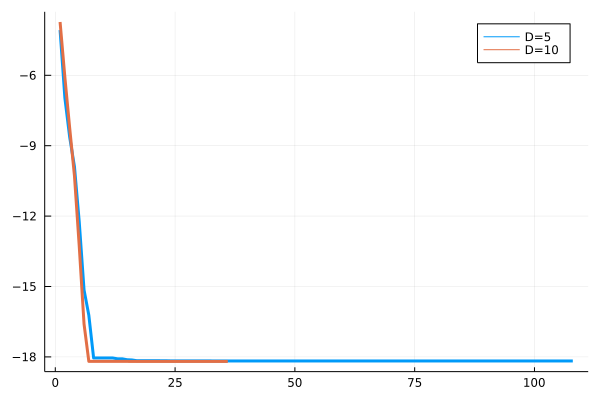

In [22]:
using Plots

fig = plot(Eigenvalues, linewidth=3, label="D=$bond_dimension")
plot!(fig, Eigenvalues2, linewidth=3, label="D=$larger_bond_dimension")

#### Try a larger problem

we are at the 1-th sweep.
we are sweep from left to right on site 1...
lowest eigenvalue at site 1 is -6.541385635162545
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -8.903174513373594
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -10.791380259432087
we are sweep from left to right on site 4...
lowest eigenvalue at site 4 is -12.895014865323832
we are sweep from left to right on site 5...
lowest eigenvalue at site 5 is -15.094301750198941
we are sweep from left to right on site 6...
lowest eigenvalue at site 6 is -17.33056566520483
we are sweep from left to right on site 7...
lowest eigenvalue at site 7 is -19.19813415182543
we are sweep from left to right on site 8...
lowest eigenvalue at site 8 is -21.329056799280806
we are sweep from left to right on site 9...
lowest eigenvalue at site 9 is -23.55517394761868
we are sweep from left to right on site 10...
lowest eigenvalue at site 10 is -25.28915928142728
we are sweep from 

lowest eigenvalue at site 15 is -104.19455996426352
we are sweep from right to left on site 14...
lowest eigenvalue at site 14 is -104.19456063823628
we are sweep from right to left on site 13...
lowest eigenvalue at site 13 is -104.19456201274949
we are sweep from right to left on site 12...
lowest eigenvalue at site 12 is -104.19456396133198
we are sweep from right to left on site 11...
lowest eigenvalue at site 11 is -104.19456432012514
we are sweep from right to left on site 10...
lowest eigenvalue at site 10 is -104.19456513671429
we are sweep from right to left on site 9...
lowest eigenvalue at site 9 is -104.19456557567962
we are sweep from right to left on site 8...
lowest eigenvalue at site 8 is -104.19456561984721
we are sweep from right to left on site 7...
lowest eigenvalue at site 7 is -104.19456562883335
we are sweep from right to left on site 6...
lowest eigenvalue at site 6 is -104.19456563078542
we are sweep from right to left on site 5...
lowest eigenvalue at site 5 i

lowest eigenvalue at site 29 is -104.19456574232126
we are sweep from right to left on site 28...
lowest eigenvalue at site 28 is -104.19456574354705
we are sweep from right to left on site 27...
lowest eigenvalue at site 27 is -104.19456574436505
we are sweep from right to left on site 26...
lowest eigenvalue at site 26 is -104.1945657461279
we are sweep from right to left on site 25...
lowest eigenvalue at site 25 is -104.19456574713413
we are sweep from right to left on site 24...
lowest eigenvalue at site 24 is -104.19456574917271
we are sweep from right to left on site 23...
lowest eigenvalue at site 23 is -104.19456575005803
we are sweep from right to left on site 22...
lowest eigenvalue at site 22 is -104.19456575141967
we are sweep from right to left on site 21...
lowest eigenvalue at site 21 is -104.19456575201453
we are sweep from right to left on site 20...
lowest eigenvalue at site 20 is -104.19456575305371
we are sweep from right to left on site 19...
lowest eigenvalue at 

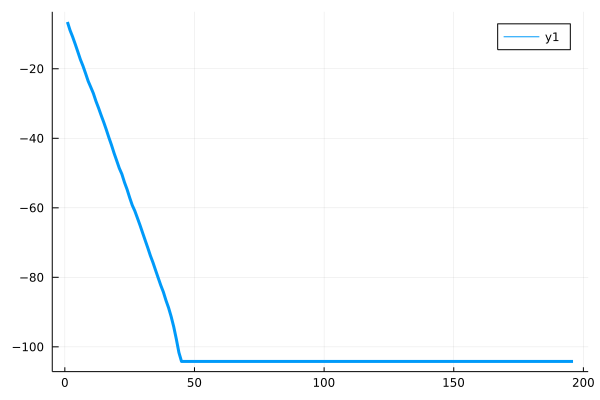

In [23]:
mpo = xxz_mpo(50, 1., 1.5, 0.5)
@time Eigenvalues, state = ground_state(mpo, D=50)
plot(Eigenvalues, linewidth=3)

#### Energy per site scaling

In [24]:
# sites = collect(10:5:60)
# Eigenvalues = Float64[]
# for n in sites
#     mpo = xxz_mpo(n, 1., 1.2, 0.5)
#     evals, state = ground_state(mpo, D=50)
#     push!(Eigenvalues, evals[end] / n)
# end

In [25]:
# fig = plot(sites, Eigenvalues, linewidth=2, linestyle=:dash, marker=:circle)
# xlabel!(fig, "L")
# ylabel!(fig, "energy per site")

## Part 4: Implementation of time-evolving block decimation (TEBD) algorithm from scratch

Second-order trotter expansion: assuming $H = H_1 + H_2 + \dots $, then we have 

$\exp(\tau H) = \exp(\tau H_1/2)\exp(\tau H_2/2)\dots \exp(\tau H_2/2)\exp(\tau H_1/2) + O(\tau^2)$

In case the Hamiltonian $\hat{H}_{XXZ}$ is __nearest neighbour__, that is, $\hat{H}_{XXZ} = \hat{H}^{even} + \hat{H}^{odd} $, where $\hat{H}^{even}_{XXZ}$ and $\hat{H}^{odd}_{XXZ}$ act on the even and odd bonds separately, then we simply have

$\exp(\tau \hat{H}_{XXZ}) = \exp(\tau \hat{H}^{even}_{XXZ}/2) \exp(\tau \hat{H}^{odd}_{XXZ})\exp(\tau \hat{H}^{even}_{XXZ}/2) + O(\tau^2)$

### A. Build the bond evolution operator for the even and odd bonds

In [26]:
# assume no magnetization, namely hz = 0
function compute_two_body_gate(J::Real, Delta::Real, dt::Real)
    sigma_x, sigma_y, sigma_z = pauli_operators()
    h = J .* (kron(sigma_x, sigma_x) + kron(sigma_y, sigma_y)) + Delta * kron(sigma_z, sigma_z)
    U = exp(-im*dt .* h)
    return reshape(U, 2, 2, 2, 2)
end

U = compute_two_body_gate(1., 1.2, 0.1)
size(U)

(2, 2, 2, 2)

### B. Prepare mps in right canonical form
- The __correct__ singular vectors are also required, which means that they correspond to the correct bipartition Schmidt numbers

In [27]:
mps = generate_random_mps(ComplexF64, 5, 2, 3)
svectors = prepare_right!(mps)
is_right_canonical(mps)

true

Singular vectors produced in this way are not the correct ones in general

In [28]:
[norm(item) for item in svectors]

4-element Vector{Float64}:
 0.7404357629683896
 1.3320355942716058
 1.8117662867014235
 2.76117054533755

The right way to go, first prepare mps in left canonical form, and then prepare it in right canonical form

In [29]:
svectors = prepare_left!(mps)
svectors = prepare_right!(mps)
[norm(item) for item in svectors]

4-element Vector{Float64}:
 0.9999999999999997
 0.9999999999999997
 0.9999999999999997
 0.9999999999999997

### C. Apply a bond evolution operator onto the mps
- We assume the mps is prepared in the right-canonical form, with all the singular vectors stored. 
- A trick to __avoid dividing by singular vectors__ is used, for details see [The density-matrix renormalization group in the age of matrix product states](https://linkinghub.elsevier.com/retrieve/pii/S0003491610001752), Section 7.3.2, Eqs.(270-274), as follows: <img src="smart_bond_evolution.jpeg" width="400" height="400" />
- The mps will keep to be right-canonical, and the singular vectors will remain to be correct with such bond evolution algorithm

In [30]:
function apply!(bond::Int, U::AbstractArray{ComplexF64, 4}, mps::Vector{<:AbstractArray{ComplexF64, 3}}, svectors::Vector{Vector{Float64}})
#     build two-ste mps
    @tensor twositemps[a, b, d, e] := mps[bond][a, b, c] * mps[bond+1][c, d, e]
#     evolve two-site mps
    @tensor twositemps1[e, a, b, f] := U[a, b, c, d] * twositemps[e, c, d, f]
    twositemps = copy(twositemps1)
#     separate two-site mps, using the algorithm of hasting
    if bond != 1
        smat = Matrix(Diagonal(svectors[bond-1]))
        @tensor twositemps1[a, c, d, e] := smat[a, b] * twositemps[b, c, d, e]
    end
    
    s1, s2, s3, s4 = size(twositemps)
    twositemps = reshape(twositemps, s1*s2, s3*s4)
    u, s, v = svd(reshape(twositemps1, s1*s2, s3*s4))
#     println("bond is $bond")
#     println(s)
    v = v'
    @tensor u[a, c] = twositemps[a, b] * conj(v[c, b])
    mps[bond] = reshape(u, s1, s2, length(s))
    mps[bond+1] = reshape(v, length(s), s3, s4)
    svectors[bond] = s
end


apply! (generic function with 1 method)

### C. Second order TEBD for a single time step <img src="tebd.jpeg" width="800" height="400" />

In [31]:
function tebd!(Uevenhalf::AbstractArray{ComplexF64, 4}, Uodd::AbstractArray{ComplexF64, 4}, mps::Vector{<:AbstractArray{ComplexF64, 3}}, svectors::Vector{Vector{Float64}})
    L = length(mps)
    for bond in 2:2:L-1
        apply!(bond, Uevenhalf, mps, svectors)
    end
    for bond in 1:2:L-1
        apply!(bond, Uodd, mps, svectors)
    end
    for bond in 2:2:L-1
        apply!(bond, Uevenhalf, mps, svectors)
    end
end

tebd! (generic function with 1 method)

### D. Example of simple quench

In [32]:
L = 11
J = 1.
Delta = 1.
sigma_x, sigma_y, sigma_z = pauli_operators()
mpo = xxz_mpo(L, J, Delta, 0.5)
Eigenvalues, mps = ground_state(mpo, D=30)
Eigenvalues

we are at the 1-th sweep.
we are sweep from left to right on site 1...
lowest eigenvalue at site 1 is -5.060657468805166
we are sweep from left to right on site 2...
lowest eigenvalue at site 2 is -7.068267617142388
we are sweep from left to right on site 3...
lowest eigenvalue at site 3 is -9.616414393865318
we are sweep from left to right on site 4...
lowest eigenvalue at site 4 is -12.562685249077825
we are sweep from left to right on site 5...
lowest eigenvalue at site 5 is -14.854880884589589
we are sweep from left to right on site 6...
lowest eigenvalue at site 6 is -18.698225244605194
we are sweep from left to right on site 7...
lowest eigenvalue at site 7 is -19.028372551062066
we are sweep from left to right on site 8...
lowest eigenvalue at site 8 is -19.02837255106204
we are sweep from left to right on site 9...
lowest eigenvalue at site 9 is -19.028372551062034
we are sweep from left to right on site 10...
lowest eigenvalue at site 10 is -19.028372551062038


we are sweep f

40-element Vector{Float64}:
  -5.060657468805166
  -7.068267617142388
  -9.616414393865318
 -12.562685249077825
 -14.854880884589589
 -18.698225244605194
 -19.028372551062066
 -19.02837255106204
 -19.028372551062034
 -19.028372551062038
 -19.02837255106204
 -19.028372551062038
 -19.028372551062024
   ⋮
 -19.028373209437905
 -19.028373209437913
 -19.028373209437913
 -19.0283732094379
 -19.028373209437884
 -19.0283732094379
 -19.02837320943789
 -19.028373209437913
 -19.028373209437934
 -19.028373209437927
 -19.028373209437934
 -19.028373209437937

In [33]:
prepare_left!(mps)
svectors = prepare_right!(mps)
[norm(item) for item in svectors]

10-element Vector{Float64}:
 1.000000000000001
 1.000000000000001
 1.000000000000001
 1.0000000000000009
 1.0000000000000009
 1.0000000000000007
 1.0000000000000004
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002

#### Measure local observables

In [34]:
# think about it!!!
function local_measurement(site::Int, op::AbstractMatrix, mps::Vector{<:AbstractArray{ComplexF64, 3}}, svectors::Vector{Vector{Float64}})
    if site == 1
        mpsj = mps[site]
    else
        v = Matrix(Diagonal(svectors[site-1]))
        @tensor mpsj[a, c, d] := v[a, b] * mps[site][b, c, d]
    end
    @tensor r[] := conj(mpsj[a, b, c]) * op[b, d] * mpsj[a, d, c]
    return r[]
end

local_measurement(1, sigma_x, mps, svectors)

5.441711656584695e-14 - 3.1554436208840472e-30im

In [35]:
zvalues = real.([local_measurement(site, sigma_z, mps, svectors) for site in 1:length(mps)])

11-element Vector{Float64}:
 -0.3150924383134396
  0.19692569938084584
 -0.37136906132789627
  0.2519501969397127
 -0.39633638082883776
  0.267843968299362
 -0.3963363808288472
  0.2519501969397201
 -0.371369061327927
  0.19692569938079182
 -0.3150924383134841

In [36]:
dt = 0.05
Delta = 0.5
Uevenhalf = compute_two_body_gate(J, Delta, dt/2)
Uodd = compute_two_body_gate(J, Delta, dt)
size(Uodd)

(2, 2, 2, 2)

In [37]:
for i in 1:20
    tebd!(Uevenhalf, Uodd, mps, svectors)
end
# println(svectors)
# tebd!(Uevenhalf, Uodd, mps, svectors)
# println(svectors)
zvalues_final = real.([local_measurement(site, sigma_z, mps, svectors) for site in 1:length(mps)])

11-element Vector{Float64}:
 -0.18912387830057703
  0.06774913739636446
 -0.22047496652348914
  0.04136328720056481
 -0.22653286775615977
  0.05501833852316547
 -0.2261788684270386
  0.040982004661068105
 -0.2202447358578667
  0.06741628460375049
 -0.1899737355198152

### Check if we are still right-canonical?

In [38]:
is_right_canonical(mps)

true

In [39]:
[norm(item) for item in svectors]

10-element Vector{Float64}:
 1.000000000000019
 1.0000000000000209
 1.0000000000000202
 1.0000000000000215
 1.0000000000000209
 1.0000000000000207
 1.0000000000000189
 1.0000000000000184
 1.0000000000000155
 1.000000000000015

In [40]:
zvalues_final = real.([local_measurement(site, sigma_z, mps, svectors) for site in 1:length(mps)])

11-element Vector{Float64}:
 -0.18912387830057703
  0.06774913739636446
 -0.22047496652348914
  0.04136328720056481
 -0.22653286775615977
  0.05501833852316547
 -0.2261788684270386
  0.040982004661068105
 -0.2202447358578667
  0.06741628460375049
 -0.1899737355198152

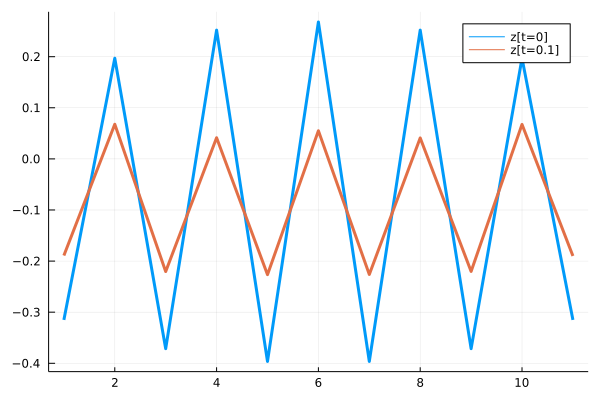

In [41]:
fig = plot(collect(1:length(zvalues)), zvalues, linewidth=3, label="z[t=0]")
plot!(fig, collect(1:length(zvalues)), zvalues_final, linewidth=3, label="z[t=0.1]")

## More advanced topics
- The algorithm side
    - Symmetries? $U(1)$ symmetric, $SU(2)$ symmetric matrix product states algorithms
    - MPO based time evolution algorithms
        - The $W^1$, $W^2$ algorithm [Time-evolving a matrix product state with long-ranged interactions](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.91.165112)
        - Time dependent variational principle (TDVP) algorithm [Unifying time evolution and optimization with matrix product states](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.94.165116)
    - **Infinite MPS** algorithms
        - Infinite variational MPS algorithm
        - Infinite TEBD algorithm
    - Generalization to two-dimensional system. Two-dimensional finite size and infinite size projected entangled pair states (PEPS) algorithm
    - Other tensor network states algorithms including tree tensor network, MERA...
- The application side
    - Application to Markovian or Lindblad open quantum systems (This generalization is fairly straightforward)
        - compute the long-time steady state, similar to the ground state of unitary system
        - Time evolution of open quantum system
    - Application to non-Markovian open quantum systems by directly evolving the system plus the environment
    - Applications in quantum information and quantum computing
    - A new framework for machine learning
    - A data structure for high-dimensional probability distribution
    - ...

A **warning**: Julia uses column-major array while python uses row-major array. Keep in mind: If you are using Julia, try not to use the two functions **reshape and kron at the same time**. Note that the function contract can be used as a substitution for kron. If you have to use these two functions in your code, just use one of them. You can use them together unless you really know what you are doing.